In [1]:
from galileojp.k3s import K3SGateway

import datetime
import json
from collections import defaultdict
import pandas as pd
from matplotlib.dates import DateFormatter
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 11})

sns.set_theme()
sns.set_context("talk")

# Telemd resource usage analysis

This notebook is dedicated to investage memory and cpu consumption of the telemd monitoring agent, across devices.

In [2]:
gw = K3SGateway.from_env()

In [3]:
exp_id = '202207170001-a5a7'

Specifically, we take a look at the following nodes:
* PC with Xeon CPU
* Nvidia Jetson Nano
* Nvidia Jetson NX
* Nvidia Jetson TX2
* Raspberry Pi 4

In [4]:
nodes = [
    ('Xeon', 'eb-b-xeongpu-0'),
    ('Nano', 'eb-a-jetson-nano-0'),
    ('NX', 'eb-a-jetson-nx-0'),
    ('TX2', 'eb-a-jetson-tx2-0'),
    ('RPI4','eb-a-rpi4-0'),
]

The `get_replica` method on the gateway only works for function pods.
We can access all replicas via `get_raw_replicas`.

Afterwards, we have to parse the replicas ourselves and retrieve the container id of the telemd instance that is running on the `eb-b-xeongpu-0` node.

In [5]:
raw_replicas = gw.get_raw_replicas(exp_id)

In [6]:
telemd_container_ids = {}
for node in nodes:
    node_name = node[0]
    hostname = node[1]
    
    # filter for telemd replicas, such that we can get the container id
    for idx, row in raw_replicas.iterrows():
        obj = json.loads(row['_value'])
        if obj['nodeName'] == hostname and 'telemd' in obj['name']:
            container_id = obj['containers']['telemd']['id'].replace('containerd://','')
            telemd_container_ids[node_name] = container_id
            break
    
telemd_container_ids

{'Xeon': '2b78b710083f3829ed6b30104a5459397f1cac23be6a48d8312d5fb844c9ae0b',
 'Nano': '5b41ac3f14059036cb881cc424eb7e3645abd6b37c73082d3ed26ed2eaf4b7cc',
 'NX': 'a0e12609d6503e985470f55ddefc31cc0c52316966a819f4ed3f736fe43a8eb6',
 'TX2': 'dc0c1e14e2ebb5b52c478aa9e6f67f77c30b86917c88f790c8124293e0195e3d',
 'RPI4': 'cbb732eca55ea31b504a5d783f63b1eadb80e02c16b8f9c7036a8f5b8024ecc6'}

Then we fetch all telemetry data, which we will filter to only get the container relevant data

In [7]:
telemetry_df = gw.preprocessed_telemetry(exp_id)

In [8]:
telemd_memories = []
for node, container_id in telemd_container_ids.items():
    memory = telemetry_df[telemetry_df['metric'] == 'kubernetes_cgrp_memory']
    memory = memory[memory['subsystem'] == container_id]
    memory['Host'] = node
    telemd_memories.append(memory)
telemd_memory_df = pd.concat(telemd_memories)
telemd_memory_df

,result,table,_start,_stop,_time,value,_field,_measurement,exp_id,metric,node,ts,subsystem,Host
ts,,,,,,,,,,,,,,
1970-01-01 00:00:00.961416877,_result,30056,1970-01-01 00:00:00+00:00,2022-07-18 12:06:12.074964+00:00,2022-07-17 00:01:13.228000+00:00,6.172672,value,telemetry,202207170001-a5a7,kubernetes_cgrp_memory,eb-b-xeongpu-0,0.961417,2b78b710083f3829ed6b30104a5459397f1cac23be6a48...,Xeon
1970-01-01 00:00:01.960627473,_result,30057,1970-01-01 00:00:00+00:00,2022-07-18 12:06:12.074964+00:00,2022-07-17 00:01:14.227000+00:00,6.758400,value,telemetry,202207170001-a5a7,kubernetes_cgrp_memory,eb-b-xeongpu-0,1.960627,2b78b710083f3829ed6b30104a5459397f1cac23be6a48...,Xeon
1970-01-01 00:00:02.959916508,_result,30058,1970-01-01 00:00:00+00:00,2022-07-18 12:06:12.074964+00:00,2022-07-17 00:01:15.226000+00:00,7.528448,value,telemetry,202207170001-a5a7,kubernetes_cgrp_memory,eb-b-xeongpu-0,2.959917,2b78b710083f3829ed6b30104a5459397f1cac23be6a48...,Xeon
1970-01-01 00:00:03.960513985,_result,30059,1970-01-01 00:00:00+00:00,2022-07-18 12:06:12.074964+00:00,2022-07-17 00:01:16.227000+00:00,8.224768,value,telemetry,202207170001-a5a7,kubernetes_cgrp_memory,eb-b-xeongpu-0,3.960514,2b78b710083f3829ed6b30104a5459397f1cac23be6a48...,Xeon
1970-01-01 00:00:04.963462508,_result,30060,1970-01-01 00:00:00+00:00,2022-07-18 12:06:12.074964+00:00,2022-07-17 00:01:17.230000+00:00,9.220096,value,telemetry,202207170001-a5a7,kubernetes_cgrp_memory,eb-b-xeongpu-0,4.963463,2b78b710083f3829ed6b30104a5459397f1cac23be6a48...,Xeon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:01:39.504901803,_result,26691,1970-01-01 00:00:00+00:00,2022-07-18 12:06:12.074964+00:00,2022-07-17 00:02:51.771000+00:00,10.366976,value,telemetry,202207170001-a5a7,kubernetes_cgrp_memory,eb-a-rpi4-0,99.504902,cbb732eca55ea31b504a5d783f63b1eadb80e02c16b8f9...,RPI4
1970-01-01 00:01:40.434292948,_result,26692,1970-01-01 00:00:00+00:00,2022-07-18 12:06:12.074964+00:00,2022-07-17 00:02:52.701000+00:00,10.366976,value,telemetry,202207170001-a5a7,kubernetes_cgrp_memory,eb-a-rpi4-0,100.434293,cbb732eca55ea31b504a5d783f63b1eadb80e02c16b8f9...,RPI4
1970-01-01 00:01:41.289717353,_result,26693,1970-01-01 00:00:00+00:00,2022-07-18 12:06:12.074964+00:00,2022-07-17 00:02:53.556000+00:00,10.465280,value,telemetry,202207170001-a5a7,kubernetes_cgrp_memory,eb-a-rpi4-0,101.289717,cbb732eca55ea31b504a5d783f63b1eadb80e02c16b8f9...,RPI4


## Memory usage as line plot

Resampled over a 5 seconds interval using mean.

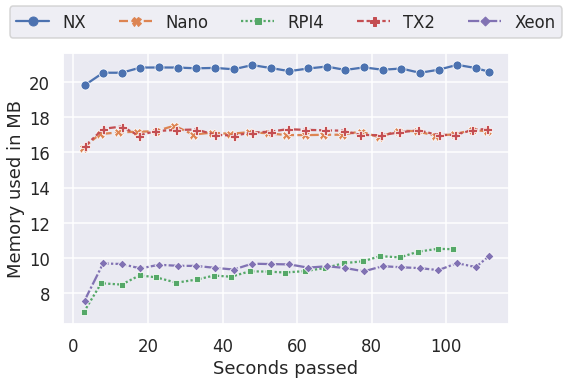

In [9]:
plt.figure(figsize = (8,5))

# Resample over a 5 seconds interval using mean
data = telemd_memory_df.groupby(['Host']).resample('5S').mean()
g = sns.lineplot(x='ts',y='value',data=data,hue='Host',dashes=True,style='Host',markers=True)
# g.set_title('Memory')
g.set_ylabel('Memory used in MB')
g.set_xlabel('Seconds passed')
g.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
           fancybox=True, shadow=False, ncol=len(nodes))
plt.savefig('figures/telemd-memory-usage-lineplot.pdf')

## Memory usage as barplot

Error bars show standard deviation

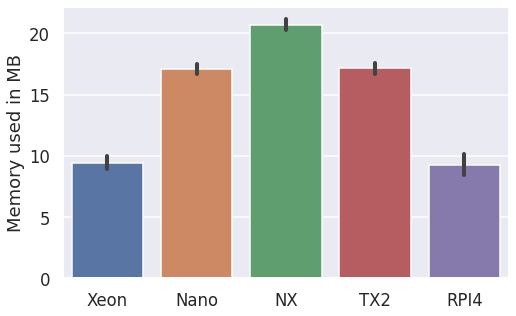

In [10]:
plt.figure(figsize = (8,5))
data = telemd_memory_df
g = sns.barplot(x='Host', y='value', data=data,ci='sd')
g.set_xlabel('')
g.set_ylabel('Memory used in MB')
plt.savefig('figures/telemd-memory-usage-lineplot.pdf')

# Telemd Container CPU usage

In [11]:
dfs = []
for node, container_id in telemd_container_ids.items():
    cpu = gw.get_cpu_container(exp_id, container_id)
    cpu['Host'] = node
    dfs.append(cpu)
telemd_cpu_df = pd.concat(dfs)
telemd_cpu_df

,result,table,_start,_stop,_time,value,_field,_measurement,exp_id,metric,node,subsystem,ts,value_ms,milli_cores,percentage,percentage_relative,Host
ts,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00.960589326,_result,0,1970-01-01 00:00:00+00:00,2022-07-18 12:06:44.028117+00:00,2022-07-17 00:01:13.227000+00:00,3.544631e+10,value,telemetry,202207170001-a5a7,kubernetes_cgrp_cpu,eb-b-xeongpu-0,2b78b710083f3829ed6b30104a5459397f1cac23be6a48...,1658016073.2274873,35446.310434,NaN,NaN,NaN,Xeon
1970-01-01 00:00:01.960807479,_result,1,1970-01-01 00:00:00+00:00,2022-07-18 12:06:44.028117+00:00,2022-07-17 00:01:14.227000+00:00,3.548949e+10,value,telemetry,202207170001-a5a7,kubernetes_cgrp_cpu,eb-b-xeongpu-0,2b78b710083f3829ed6b30104a5459397f1cac23be6a48...,1658016074.2277055,35489.494381,43.174528,4.317453,1.079363,Xeon
1970-01-01 00:00:02.959729111,_result,2,1970-01-01 00:00:00+00:00,2022-07-18 12:06:44.028117+00:00,2022-07-17 00:01:15.226000+00:00,3.553106e+10,value,telemetry,202207170001-a5a7,kubernetes_cgrp_cpu,eb-b-xeongpu-0,2b78b710083f3829ed6b30104a5459397f1cac23be6a48...,1658016075.226627,35531.064974,41.561526,4.156153,1.039038,Xeon
1970-01-01 00:00:03.961730635,_result,3,1970-01-01 00:00:00+00:00,2022-07-18 12:06:44.028117+00:00,2022-07-17 00:01:16.228000+00:00,3.557421e+10,value,telemetry,202207170001-a5a7,kubernetes_cgrp_cpu,eb-b-xeongpu-0,2b78b710083f3829ed6b30104a5459397f1cac23be6a48...,1658016076.2286286,35574.211393,43.137009,4.313701,1.078425,Xeon
1970-01-01 00:00:04.963192618,_result,4,1970-01-01 00:00:00+00:00,2022-07-18 12:06:44.028117+00:00,2022-07-17 00:01:17.230000+00:00,3.563819e+10,value,telemetry,202207170001-a5a7,kubernetes_cgrp_cpu,eb-b-xeongpu-0,2b78b710083f3829ed6b30104a5459397f1cac23be6a48...,1658016077.2300906,35638.188088,63.962741,6.396274,1.599069,Xeon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:01:38.975937760,_result,98,1970-01-01 00:00:00+00:00,2022-07-18 12:07:04.424404+00:00,2022-07-17 00:02:51.242000+00:00,3.685484e+11,value,telemetry,202207170001-a5a7,kubernetes_cgrp_cpu,eb-a-rpi4-0,cbb732eca55ea31b504a5d783f63b1eadb80e02c16b8f9...,1658016171.2428358,368548.446891,254.332100,25.433210,6.358302,RPI4
1970-01-01 00:01:39.985259450,_result,99,1970-01-01 00:00:00+00:00,2022-07-18 12:07:04.424404+00:00,2022-07-17 00:02:52.252000+00:00,3.687252e+11,value,telemetry,202207170001-a5a7,kubernetes_cgrp_cpu,eb-a-rpi4-0,cbb732eca55ea31b504a5d783f63b1eadb80e02c16b8f9...,1658016172.2521574,368725.212648,176.041245,17.604124,4.401031,RPI4
1970-01-01 00:01:40.975912965,_result,100,1970-01-01 00:00:00+00:00,2022-07-18 12:07:04.424404+00:00,2022-07-17 00:02:53.242000+00:00,3.688803e+11,value,telemetry,202207170001-a5a7,kubernetes_cgrp_cpu,eb-a-rpi4-0,cbb732eca55ea31b504a5d783f63b1eadb80e02c16b8f9...,1658016173.242811,368880.317274,154.468897,15.446890,3.861722,RPI4


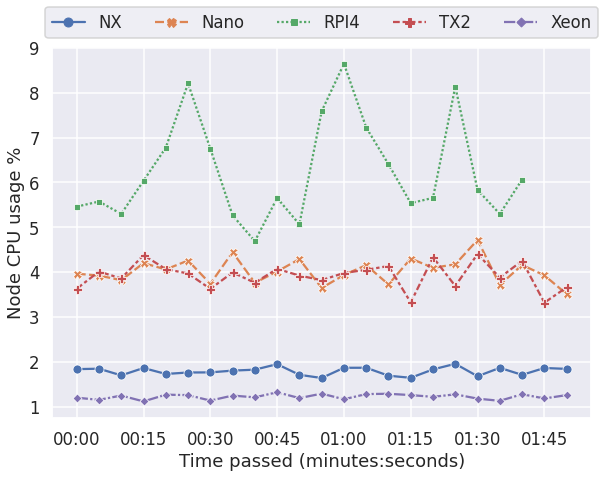

In [23]:
plt.figure(figsize = (9,7))

# Show minutes and seconds
time_format = "%M:%S"
time_form = DateFormatter(time_format)

data = telemd_cpu_df.groupby(['Host']).resample('5S').mean()
g = sns.lineplot(x='ts',y='percentage_relative',hue='Host',data=data,style='Host',dashes=True,markers=True)
g.set_ylabel('Node CPU usage %')
g.legend(loc='upper center', bbox_to_anchor=(0.5, 1.13),
           fancybox=True, shadow=False, ncol=len(nodes))
g.xaxis.set_major_formatter(time_form)
g.set_xlabel('Time passed (minutes:seconds)')
plt.savefig('figures/telemd-relative-cpu-usage-lineplot.pdf')
plt.tight_layout()

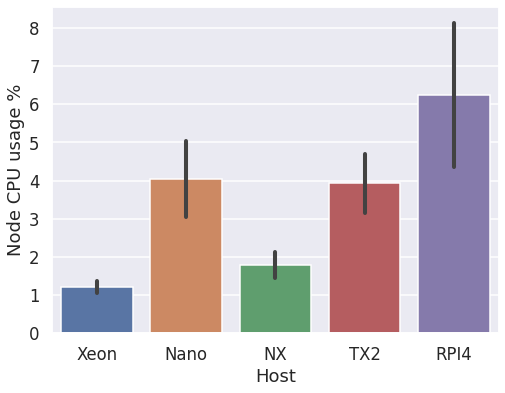

In [24]:
plt.figure(figsize = (8,6))

g = sns.barplot(x='Host', y='percentage_relative', data=telemd_cpu_df, ci='sd')
g.set_ylabel('Node CPU usage %')

plt.savefig('figures/telemd-relative-cpu-usage-barplot.pdf')